### Importing Libraries


In [3]:
import numpy as np
import random
from collections import deque
import matplotlib.pyplot as plt
from itertools import product
from IPython.display import clear_output

### Python Version

In [4]:
import sys
print(sys.executable)
print(sys.version)

/Users/dorianagiovarruscio/.pyenv/versions/3.12.4/bin/python
3.12.4 (main, Sep 30 2024, 12:21:56) [Clang 15.0.0 (clang-1500.3.9.4)]


### GridWorld Class

The `GridWorld` class defines a grid-based environment for reinforcement learning tasks. It includes dynamic obstacles (doors), fixed obstacles (walls) and a goal location. The agent starts at a random position on the bottom row and must navigate to the goal at the top row.

#### Key Features:
1. **Grid Initialization:**
   - The grid is a 10x10 (or 5x5) matrix initialized with `-1`.
   - The agent starts at a random position on the bottom row.
   - The goal is placed at a random position on the top row .

2. **Dynamic Obstacles (Doors):**
   - Doors are placed at predefined locations.
   - Each door has a random status (`open` or `closed`).
   - The base probability of a door being open is **0.3**, but this probability is adjusted dynamically:
     - If the door is part of the shortest path from the agent's start position to the goal, the probability of it being open increases to **0.6**.
     - A small random variation is added to the probability to introduce stochasticity.
   - This dynamic adjustment ensures that doors on the optimal path are more likely to be open, encouraging the agent to explore efficient routes.
   
3. **Fixed Obstacles (Walls):**
   - Walls are placed around doors based on their positions (horizontal or vertical).

4. **Agent Actions:**
   - The agent can move `UP`, `DOWN`, `LEFT`, or `RIGHT`.
   - Movement is restricted by walls, closed doors, and grid boundaries.

5. **Rewards:**
   - `+5`: Reaching the goal.
   - `+0.05`: Passing through an open door.
   - `-1`: Hitting a wall.
   - `-0.1`: Normal movement.

6. **Pathfinding with BFS:**
   - The `bfs` method finds the shortest path from the agent's current position to the goal.

7. **Dynamic Door Updates:**
   - The `update_doors` method adjusts door statuses based on their presence in the shortest path.

8. **Step Execution:**
   - The `make_step` method moves the agent, updates door statuses, calculates rewards and checks if the goal is reached.

#### Methods:
- `__init__`: Initializes the grid, agent, goal, doors and walls.
- `reset`: Resets the environment for a new episode.
- `get_available_actions`: Returns the list of possible actions.
- `agent_on_map`: Displays the agent's current position on the grid.
- `get_reward`: Calculates the reward for a given position.
- `move`: Executes a movement action and returns the new position.
- `bfs`: Finds the shortest path to the goal using Breadth-First Search.
- `update_doors`: Updates the status of doors based on the optimal path.
- `make_step`: Executes a step, updates the environment and returns the reward and `done` status.
- `get_state`: Returns the current state as the agent's position and door statuses.

In [13]:
class GridWorld:
    ## Initialize starting data
    def __init__(self):
        # Set information about the gridworld
        self.height = 5
        self.width = 5
        self.grid = np.zeros((self.height, self.width)) - 1
        
        # Set random start location for the agent
        self.current_location = (4, np.random.randint(0, 4)) #(9, np.random.randint(0, 9)) for the grid 10x10
        self.initial_location = self.current_location  
        
        # Set goal location
        self.goal_location = (0, np.random.randint(0, 4)) #(9, np.random.randint(0, 9)) for the grid 10x10
        
        # Set available actions
        self.actions = ['UP', 'DOWN', 'LEFT', 'RIGHT']
        
        # Add dynamic obstacles (doors) with a probability of being open or closed
        # Example locations of doors
        self.doors = [(2, 2), (3, 1)] #(6,8),(8,1),(2,8) doors to add for the 10x10 Grid 
        self.door_status = {door: random.choice([True, False]) for door in self.doors}  # True for open, False for closed
        self.door_probability = 0.3  # 30% chance that a door is open
        
        # Add fixed obstacles (walls) around doors
        self.walls = []
        for door in self.doors:
            x, y = door
            if x % 2 == 0:  # Se la porta è su una riga pari, metti muri ai lati orizzontali
                if y > 0: self.walls.append((x, y - 1))  # Muro a sinistra
                if y < self.width - 1: self.walls.append((x, y + 1))  # Muro a destra
            else:  # Se la porta è su una riga dispari, metti muri sopra e sotto
                if x > 0: self.walls.append((x - 1, y))  # Muro sopra
                if x < self.height - 1: self.walls.append((x + 1, y))  # Muro sotto
        
        # Ensure walls are unique
        self.walls = list(set(self.walls))

    def reset(self):
        """Reset the environment for a new episode"""
        # Reset agent position to a random position on the bottom row
        self.current_location = (4, np.random.randint(0, 4)) #(9, np.random.randint(0, 9)) for the grid 10x10
        
        # Reset door statuses
        self.door_status = {door: random.choice([True, False]) for door in self.doors}
        
        return self.get_state()

    def get_available_actions(self):
        """Returns possible actions"""
        return self.actions
    
    def agent_on_map(self):
        """Prints out current location of the agent on the grid"""
        grid = np.zeros((self.height, self.width))
        grid[self.current_location[0], self.current_location[1]] = 1
        return grid
    
    def get_reward(self, new_location):
        if new_location == self.goal_location:
            return 5  # Goal raggiunto (aumentato il premio)
        elif new_location in self.doors and self.door_status[new_location]:
            return 0.05  # Porta aperta
        elif new_location in self.walls:
            return -1  # Ostacolo
        return -0.1  # Movimento normale
    
    def move(self, position, action):
        new_pos = {
            'UP': (position[0] - 1, position[1]),
            'DOWN': (position[0] + 1, position[1]),
            'LEFT': (position[0], position[1] - 1),
            'RIGHT': (position[0], position[1] + 1)
        }[action]

        # Verifica che la nuova posizione sia dentro i confini e non un muro
        if (0 <= new_pos[0] < self.height and 0 <= new_pos[1] < self.width and 
            new_pos not in self.walls):
            if new_pos in self.doors and not self.door_status[new_pos]:
                return position  # La porta è chiusa, resta fermo
            return new_pos
        return position  # Se il movimento è invalido, resta fermo

    def bfs(self):
        """Finds the shortest path using BFS"""
        queue = deque([(self.current_location, [])])  # (position, path)
        visited = set()
        visited.add(self.current_location)
        
        while queue:
            current, path = queue.popleft()
            
            if current == self.goal_location:
                return path  # Return the path (list of positions)
            
            for action in self.actions:
                next_pos = self.move(current, action)
                if next_pos != current and next_pos not in visited:
                    visited.add(next_pos)
                    queue.append((next_pos, path + [next_pos]))
        
        return []  # In case there is no path (shouldn't happen)

    def update_doors(self):
        """Aggiorna lo stato delle porte basandosi sul percorso"""
        path = self.bfs()  # Trova il percorso ottimale

        for door in self.doors:
            prob = 0.3  # Probabilità base
            if door in path:
                prob = 0.6  # Alta probabilità se la porta è sul percorso
            
            prob += random.uniform(-0.05, 0.05)  # Aggiunge una piccola variazione casuale
            prob = max(0, min(1, prob))  # Limita tra 0 e 1
            self.door_status[door] = random.random() < prob  # Stato porta basato sulla probabilità
    
    def make_step(self, action):
        """Moves the agent and returns reward"""
        # First, update the doors
        self.update_doors()
        
        last_location = self.current_location
        
        # Move the agent in the chosen direction
        self.current_location = self.move(last_location, action)
        
        reward = self.get_reward(self.current_location)
        done = self.current_location == self.goal_location
        
        return reward, done
    
    def get_state(self):
        """Returns the current state as position and door statuses"""
        door_status_tuple = tuple(self.door_status[door] for door in self.doors)
        return (self.current_location, door_status_tuple)



### Agent Classes

This cell defines two agent classes: `RandomAgent` and `Q_Agent`. These agents interact with the `GridWorld` environment, with the `RandomAgent` making random decisions and the `Q_Agent` implementing Q-learning for reinforcement learning.

---

#### 1. **RandomAgent**
A simple agent that selects actions randomly without learning from the environment.

- **Methods:**
  - `choose_action(available_actions)`: Chooses a random action from the list of available actions.
  - `learn(*args, **kwargs)`: Placeholder method; the random agent does not learn.

---

#### 2. **Q_Agent**
An agent that uses the Q-learning algorithm to learn an optimal policy for navigating the environment.

- **Attributes:**
  - `environment`: The environment the agent interacts with.
  - `q_table`: A dictionary storing Q-values for state-action pairs. It is lazily initialized.
  - `actions`: The list of available actions in the environment.
  - `k`: A parameter controlling the scaling of learning and exploration rates.
  - `gamma`: The discount factor for future rewards.
  - `epsilon`: The exploration rate, dynamically updated over time.
  - `alpha`: The learning rate, dynamically updated over time.
  - `time_step`: A counter tracking the number of steps taken.
  - `exploration_rate`: A list tracking the exploration rate over time.
  - `learning_rate`: A list tracking the learning rate over time.
  - `goals_reached`: A counter for the number of times the agent reaches the goal.

- **Methods:**
  1. **`choose_action(available_actions)`**:
     - Implements an epsilon-greedy policy:
       - With probability `epsilon`, the agent explores by choosing a random action.
       - Otherwise, it exploits by choosing the action with the highest Q-value.
     - Ensures the current state exists in the Q-table, initializing it if necessary.

  2. **`learn(old_state, action, reward, new_state, done)`**:
     - Updates the Q-values using the Q-learning formula:
       - If the episode is done, the Q-value is updated based only on the immediate reward.
       - Otherwise, the Q-value is updated based on the reward and the maximum Q-value of the next state.
     - Dynamically updates `epsilon` (exploration rate) and `alpha` (learning rate) based on the time step.
     - Tracks exploration and learning rates over time.
     - Increments the `goals_reached` counter when the goal is achieved.
**Q-Learning Formula:**

- If the episode is not done:
  \[
  Q(s, a) \gets Q(s, a) + \alpha \big( r + \gamma \max_{a'} Q(s', a') - Q(s, a) \big)
  \]

- If the episode is done:
  \[
  Q(s, a) \gets Q(s, a) + \alpha \big( r - Q(s, a) \big)
  \]

#### Key Features:
- **Epsilon-Greedy Policy:** Balances exploration and exploitation dynamically using `epsilon`.
- **Dynamic Learning Rate:** The learning rate (`alpha`) decreases over time, controlled by the parameter `k`.
- **Goal Tracking:** Tracks the number of times the agent successfully reaches the goal.
- **Lazy Initialization of Q-Table:** States are added to the Q-table only when encountered.

This implementation allows the `Q_Agent` to learn an optimal policy over time while balancing exploration and exploitation.

In [14]:
class RandomAgent:
    def __init__(self):
        pass
        
    def choose_action(self, available_actions):
        return np.random.choice(available_actions)
    
    def learn(self, *args, **kwargs):
        pass  # Random agent doesn't learn


class Q_Agent:
    def __init__(self, environment, k=2, gamma=0.9):
        self.environment = environment
        self.q_table = {}  # Creazione lazy della Q-table
        self.actions = environment.get_available_actions()
        
        # Parametri per il calcolo di epsilon e alpha
        self.k = k
        self.c1 = 10**k
        self.c2 = 2 * 10**k
        self.time_step = 0  # Contatore temporale
        
        # Valori iniziali
        self.epsilon = self.c1 / (self.c2 + self.time_step)
        self.alpha = self.c1 / (self.c2 + self.time_step)
        self.gamma = gamma
        
        # Per tracciare l'apprendimento
        self.exploration_rate = []
        self.learning_rate = []
        self.goals_reached = 0
    
    def choose_action(self, available_actions):
        current_state = self.environment.get_state()
        
        # Assicura che lo stato esista nella Q-table
        if current_state not in self.q_table:
            self.q_table[current_state] = {action: 0 for action in self.actions}
        
        # Epsilon-greedy policy
        if np.random.uniform(0, 1) < self.epsilon:
            # Esplorazione: azione casuale
            return np.random.choice(available_actions)
        else:
            # Sfruttamento: azione con il valore Q più alto
            q_values = self.q_table[current_state]
            max_q = max(q_values.values())
            best_actions = [a for a, q in q_values.items() if q == max_q]
            return np.random.choice(best_actions)
    
    def learn(self, old_state, action, reward, new_state, done):
        # Incrementa il contatore temporale
        self.time_step += 1
        
        # Aggiorna epsilon e alpha secondo la formula
        self.epsilon = self.c1 / (self.c2 + self.time_step)
        self.alpha = self.c1 / (self.c2 + self.time_step)
        
        # Salva i valori per tracciamento
        self.exploration_rate.append(self.epsilon)
        self.learning_rate.append(self.alpha)
        
        # Inizializza stati se non presenti
        if old_state not in self.q_table:
            self.q_table[old_state] = {a: 0 for a in self.actions}
        if new_state not in self.q_table:
            self.q_table[new_state] = {a: 0 for a in self.actions}
        
        # Formula di aggiornamento Q-learning
        if done:
            # Se l'episodio è terminato, non c'è stato futuro
            self.q_table[old_state][action] += self.alpha * (reward - self.q_table[old_state][action])
            # Incrementa goal_reached solo se abbiamo veramente raggiunto l'obiettivo
            self.goals_reached += 1
        else:
            max_q_new = max(self.q_table[new_state].values())
            self.q_table[old_state][action] += self.alpha * (
                reward + self.gamma * max_q_new - self.q_table[old_state][action]
            )

**Episodio**

### `play` Function

The `play` function runs multiple episodes of an agent interacting with the environment. It allows the agent to learn and improve its policy over time while tracking performance metrics such as rewards, steps, and goals reached.

---

#### Parameters:
- **`environment`**: The environment in which the agent operates (e.g., `GridWorld`).
- **`agent`**: The agent interacting with the environment (e.g., `RandomAgent` or `Q_Agent`).
- **`episodes`** *(int)*: The number of episodes to run .
- **`max_steps`** *(int)*: The maximum number of steps per episode .
- **`learn`** *(bool)*: Whether the agent should learn during the episodes (default: `True`).
- **`render`** *(bool)*: Whether to render the environment during the episodes (default: `False`).

---

#### Workflow:
1. **Initialization:**
   - Initializes lists to track rewards and steps per episode.
   - Tracks the number of goals reached.

2. **Episode Loop:**
   - For each episode:
     - Resets the environment and initializes the total reward for the episode.
     - Runs a loop for a maximum of `max_steps`.

3. **Step Loop:**
   - For each step:
     - The agent chooses an action using its `choose_action` method.
     - The environment executes the action using `make_step`, returning the reward and whether the goal is reached (`done`).
     - The agent learns from the experience (if learning is enabled) using the `learn` method.
     - Updates the current state to the new state.
     - Optionally renders the environment every 50 episodes if `render` is enabled.
     - Breaks the loop if the goal is reached.

4. **Parameter Decay:**
   - If the agent supports hyperparameter decay (e.g., epsilon or alpha), it is applied after each episode.

5. **Tracking Metrics:**
   - Tracks the total reward and number of steps for each episode.
   - Prints progress every 50 episodes, including:
     - Average reward over the last 50 episodes.
     - Total goals reached and success rate.

6. **Return Values:**
   - Returns three metrics:
     - `rewards_per_episode`: List of total rewards for each episode.
     - `steps_per_episode`: List of steps taken in each episode.
     - `goals_reached`: Total number of goals reached across all episodes.

---


In [16]:
def play(environment, agent, episodes=500, max_steps=200, learn=True, render=False):
    #max_steps=500 for the 10x10 grid
    """Run episodes for the agent in the environment."""
    rewards_per_episode = []
    steps_per_episode = []
    goals_reached = 0
    
    for episode in range(episodes):
        state = environment.reset()
        total_reward = 0
        
        for step in range(max_steps):
            action = agent.choose_action(environment.get_available_actions())
            
            reward, done = environment.make_step(action)
            total_reward += reward
            
            new_state = environment.get_state()
            
            if learn:
                agent.learn(state, action, reward, new_state, done)
            
            state = new_state
            
            if render and episode % 50 == 0:
                print(f"Episode {episode}, Step {step}, Action: {action}, Reward: {reward}")
                print(environment.agent_on_map())
            
            if done:
                goals_reached += 1
                break
        
        if learn and hasattr(agent, 'decay_hyperparameters'):
            agent.decay_hyperparameters(episode, episodes)
        
        rewards_per_episode.append(total_reward)
        steps_per_episode.append(step + 1)
        
        if episode % 50 == 0:
            print(f"Episode {episode}/{episodes}, Avg Reward: {np.mean(rewards_per_episode[-50:]):.2f}, " + 
                  f"Goals: {goals_reached}/{episode+1} ({goals_reached/(episode+1)*100:.1f}%)")
    
    return rewards_per_episode, steps_per_episode, goals_reached


### Experiment Execution

This cell runs experiments to compare the performance of a `RandomAgent` and a `Q_Agent` in the `GridWorld` environment. It evaluates their performance over multiple episodes and visualizes the results.

---

#### Workflow:
1. **Set Random Seed:**
   - `np.random.seed(42)` ensures reproducibility of the experiments.

2. **Random Agent Experiment:**
   - Initializes a `GridWorld` environment and a `RandomAgent`.
   - Runs 3000 episodes with the `RandomAgent` using the `play` function.
   - Tracks rewards, steps, and goals reached.

3. **Q-Learning Agent Experiment:**
   - Initializes a new `GridWorld` environment and a `Q_Agent`.
   - Runs (n) episodes with the `Q_Agent` using the `play` function.
   - Enables learning (`learn=True`) for the `Q_Agent`.
   - Tracks rewards, steps, and goals reached.

4. **Result Visualization:**
   - Plots three graphs to compare the performance of the two agents:
     1. **Total Rewards per Episode:**
        - Compares the cumulative rewards achieved by the `RandomAgent` and the `Q_Agent`.
     2. **Steps per Episode:**
        - Compares the number of steps taken by the `RandomAgent` and the `Q_Agent` to complete each episode.
     3. **Exploration Rate (Epsilon):**
        - Shows the decay of the exploration rate (`epsilon`) for the `Q_Agent` over episodes.

5. **Final Statistics:**
   - Prints summary statistics for both agents:
     - Total goals reached.
     - Average reward per episode.
     - Average steps per episode.

---

#### Visualizations:
1. **Reward Comparison:**
   - X-axis: Episode number.
   - Y-axis: Total reward per episode.
   - Compares the performance of the `RandomAgent` and the `Q_Agent`.

2. **Steps Comparison:**
   - X-axis: Episode number.
   - Y-axis: Steps taken per episode.
   - Highlights the efficiency of the `Q_Agent` compared to the `RandomAgent`.

3. **Exploration Rate Decay:**
   - X-axis: Episode number.
   - Y-axis: Exploration rate (`epsilon`).
   - Shows how the `Q_Agent` transitions from exploration to exploitation over time.

---

#### Example Output:
- **Reward Comparison:**
  - The `Q_Agent` is expected to achieve higher rewards over time as it learns an optimal policy.
  - The `RandomAgent` achieves lower and more inconsistent rewards.

- **Steps Comparison:**
  - The `Q_Agent` is expected to take fewer steps per episode as it learns to navigate efficiently.
  - The `RandomAgent` takes a random number of steps, often inefficiently.

- **Exploration Rate Decay:**
  - The `Q_Agent` starts with a high exploration rate (`epsilon`) and gradually reduces it as it learns.

---



Episode 0/500, Avg Reward: -7.05, Goals: 1/1 (100.0%)
Episode 50/500, Avg Reward: -3.01, Goals: 49/51 (96.1%)
Episode 100/500, Avg Reward: -1.55, Goals: 98/101 (97.0%)
Episode 150/500, Avg Reward: -5.14, Goals: 142/151 (94.0%)
Episode 200/500, Avg Reward: -2.10, Goals: 191/201 (95.0%)
Episode 250/500, Avg Reward: -2.49, Goals: 237/251 (94.4%)
Episode 300/500, Avg Reward: -3.76, Goals: 282/301 (93.7%)
Episode 350/500, Avg Reward: -3.98, Goals: 326/351 (92.9%)
Episode 400/500, Avg Reward: -2.73, Goals: 375/401 (93.5%)
Episode 450/500, Avg Reward: -2.04, Goals: 422/451 (93.6%)
Episode 0/500, Avg Reward: 0.50, Goals: 1/1 (100.0%)
Episode 50/500, Avg Reward: 2.70, Goals: 51/51 (100.0%)
Episode 100/500, Avg Reward: 4.07, Goals: 101/101 (100.0%)
Episode 150/500, Avg Reward: 4.29, Goals: 151/151 (100.0%)
Episode 200/500, Avg Reward: 4.23, Goals: 201/201 (100.0%)
Episode 250/500, Avg Reward: 4.39, Goals: 251/251 (100.0%)
Episode 300/500, Avg Reward: 4.26, Goals: 301/301 (100.0%)
Episode 350/500

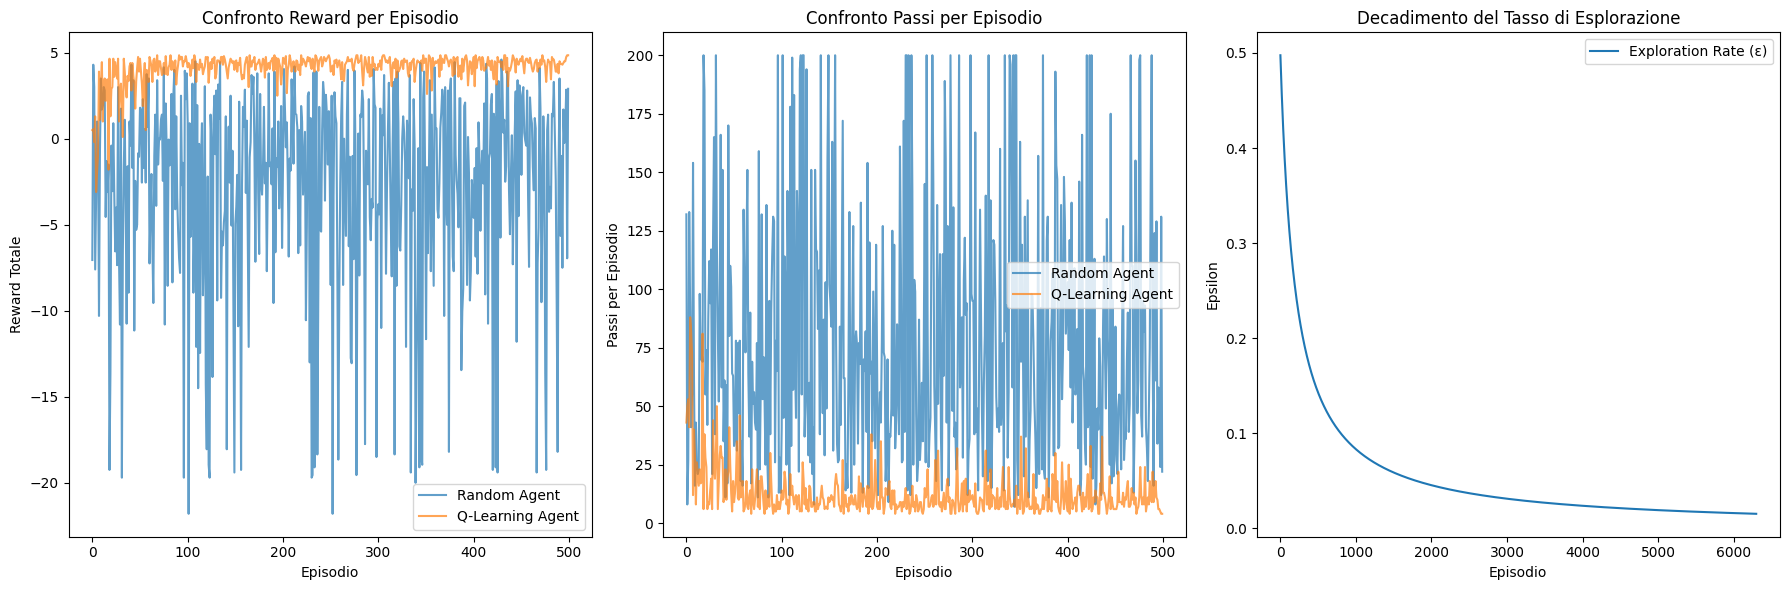


Statistiche Random Agent:
Goal raggiunti: 468/1000 (93.6%)
Reward medio: -2.93
Passi medi: 79.28

Statistiche Q-Learning Agent:
Goal raggiunti: 500/1000 (100.0%)
Reward medio: 4.11
Passi medi: 12.60


In [17]:
# Esegui esperimenti
np.random.seed(42)  # Per riproducibilità

# Inizializza ambiente e agente Random
environment_random = GridWorld()
random_agent = RandomAgent()

# Esegui 500 episodi con l'agente Random
rewards_random, steps_random, goals_random = play(
    environment_random, random_agent, episodes=500, render=False #5000 episodes for the 10x10 grid
)

# Inizializza nuovo ambiente e agente Q-Learning
environment_q = GridWorld()
q_agent = Q_Agent(environment_q)

# Esegui 500 episodi con Q-learning
rewards_q, steps_q, goals_q = play(
    environment_q, q_agent, episodes=500, learn=True, render=False #5000 episodes for the 10x10 grid
)

# Visualizzazione risultati
plt.figure(figsize=(18, 6))

# Grafico rewards
plt.subplot(1, 3, 1)
plt.plot(rewards_random, label="Random Agent", alpha=0.7)
plt.plot(rewards_q, label="Q-Learning Agent", alpha=0.7)
plt.xlabel("Episodio")
plt.ylabel("Reward Totale")
plt.title("Confronto Reward per Episodio")
plt.legend()

# Grafico steps
plt.subplot(1, 3, 2)
plt.plot(steps_random, label="Random Agent", alpha=0.7)
plt.plot(steps_q, label="Q-Learning Agent", alpha=0.7)
plt.xlabel("Episodio")
plt.ylabel("Passi per Episodio")
plt.title("Confronto Passi per Episodio")
plt.legend()

# Grafico epsilon
plt.subplot(1, 3, 3)
plt.plot(q_agent.exploration_rate, label="Exploration Rate (ε)")
plt.xlabel("Episodio")
plt.ylabel("Epsilon")
plt.title("Decadimento del Tasso di Esplorazione")
plt.legend()

plt.tight_layout()
plt.show()

# Stampa statistiche finali
print(f"\nStatistiche Random Agent:")
print(f"Goal raggiunti: {goals_random}/1000 ({goals_random/500*100:.1f}%)")
print(f"Reward medio: {np.mean(rewards_random):.2f}")
print(f"Passi medi: {np.mean(steps_random):.2f}")

print(f"\nStatistiche Q-Learning Agent:")
print(f"Goal raggiunti: {goals_q}/1000 ({goals_q/500*100:.1f}%)")
print(f"Reward medio: {np.mean(rewards_q):.2f}")
print(f"Passi medi: {np.mean(steps_q):.2f}")



### `animate_episode` Function

The `animate_episode` function visualizes an agent's interaction with the environment over a single episode. It optionally saves the animation as a GIF.

---

#### Parameters:
- **`env`**: The environment in which the agent operates (e.g., `GridWorld`).
- **`agent`**: The agent interacting with the environment.
- **`max_steps`** *(int)*: The maximum number of steps allowed in the episode .
- **`delay`** *(float)*: The delay (in seconds) between frames of the animation (default: 0.5).
- **`save_gif`** *(bool)*: Whether to save the animation as a GIF (default: `False`).
- **`gif_name`** *(str)*: The name of the output GIF file (default: `"episode.gif"`).

---

#### Workflow:
1. **Environment Reset:**
   - Resets the environment to its initial state.
   - Initializes variables to track rewards and frames for the animation.

2. **Step Loop:**
   - For each step (up to `max_steps`):
     - Creates a visualization of the current state of the environment:
       - Displays walls, doors, the agent's position, and the goal.
       - Adds a legend and grid coordinates for clarity.
     - Saves the current frame as an image for the GIF.
     - The agent chooses an action using its `choose_action` method.
     - Executes the action in the environment using `make_step`, updating the reward and checking if the goal is reached.
     - If the goal is reached, displays the final state and breaks the loop.

3. **GIF Saving:**
   - If `save_gif=True`, saves the collected frames as a GIF using the `Pillow` library.

4. **Return Value:**
   - Returns a list of rewards collected during the episode.

---

#### Key Features:
1. **Visualization:**
   - Displays the environment's state at each step, including:
     - Walls (gray), doors (red/green), the agent (blue), and the goal (gold).
     - Grid coordinates for better understanding of positions.
     - A legend explaining the grid elements.

2. **Dynamic Updates:**
   - Updates the grid and title at each step to reflect the agent's progress and the environment's state.

3. **GIF Export:**
   - Saves the animation as a GIF if `save_gif=True`, allowing for easy sharing and analysis.

4. **Goal Detection:**
   - Stops the animation and displays the final state when the agent reaches the goal.

---

In [18]:
import time
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.patches import Rectangle
import numpy as np
from IPython.display import clear_output
from PIL import Image

def animate_episode(env, agent, max_steps=100, delay=0.5, save_gif=False, gif_name="episode.gif"):
    """
    Anima un episodio e opzionalmente salva il risultato come GIF.
    
    Parametri:
    - env: Ambiente
    - agent: Agente che prende le decisioni
    - max_steps: Numero massimo di passi prima di terminare l'episodio
    - delay: Tempo di attesa tra i frame dell'animazione
    - save_gif: Se True, salva l'episodio come GIF
    - gif_name: Nome del file GIF di output
    """
    state = env.reset()
    total_reward = 0
    rewards = []
    frames = []  # Lista per salvare i frame dell'animazione

    for step in range(max_steps):
        # Crea la figura
        fig, ax = plt.subplots(figsize=(10, 8))

        # Crea una griglia pulita
        grid = np.zeros((env.height, env.width))
        cmap = mcolors.ListedColormap(['white', 'red', 'green', 'gray', 'blue', 'gold'])
        bounds = [-0.5, 0.5, 1.5, 2.5, 3.5, 4.5, 5.5]
        norm = mcolors.BoundaryNorm(bounds, cmap.N)
        
        # Aggiungi elementi alla griglia
        for wall in env.walls:
            grid[wall] = 3
        for door in env.doors:
            grid[door] = 2 if env.door_status[door] else 1
        grid[env.goal_location] = 5
        grid[env.current_location] = 4
        
        ax.imshow(grid, cmap=cmap, norm=norm)
        
        # Aggiungi legenda
        legend_elements = [
            Rectangle((0, 0), 1, 1, color='white', label='Spazio vuoto'),
            Rectangle((0, 0), 1, 1, color='red', label='Porta chiusa'),
            Rectangle((0, 0), 1, 1, color='green', label='Porta aperta'),
            Rectangle((0, 0), 1, 1, color='gray', label='Muro'),
            Rectangle((0, 0), 1, 1, color='blue', label='Agente'),
            Rectangle((0, 0), 1, 1, color='gold', label='Goal')
        ]
        ax.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1.05, 1))
        
        # Mostra le coordinate
        for i in range(env.height):
            for j in range(env.width):
                ax.text(j, i, f'({i},{j})', ha='center', va='center', color='black', fontsize=8)
        
        # Titolo con informazioni
        door_status_str = ", ".join([f"Door{i+1}={'Open' if status else 'Closed'}" 
                              for i, (door, status) in enumerate(env.door_status.items())])
        ax.set_title(f"Step: {step} | Reward: {total_reward:.1f}\nDoor Status: {door_status_str}")
        
        ax.grid(True, alpha=0.3)
        plt.tight_layout()

        # Salva il frame come immagine
        fig.canvas.draw()
        image = np.array(fig.canvas.renderer.buffer_rgba())
        frames.append(Image.fromarray(image))

        clear_output(wait=True)
        plt.show()
        
        # Esegui l'azione
        action = agent.choose_action(env.get_available_actions())
        reward, done = env.make_step(action)
        rewards.append(reward)
        total_reward += reward
        
        # Controlla se l'episodio è terminato
        if done:
            # Visualizza lo stato finale
            plt.figure(figsize=(10, 8))
            
            # Aggiorna la griglia con lo stato finale
            grid = np.zeros((env.height, env.width))
            for wall in env.walls:
                grid[wall] = 3
            for door in env.doors:
                grid[door] = 2 if env.door_status[door] else 1
            grid[env.goal_location] = 5
            grid[env.current_location] = 4
            
            plt.imshow(grid, cmap=cmap, norm=norm)
            plt.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1.05, 1))
            
            for i in range(env.height):
                for j in range(env.width):
                    plt.text(j, i, f'({i},{j})', ha='center', va='center', color='black', fontsize=8)
            
            plt.title(f"GOAL REACHED! | Final Step: {step+1} | Total Reward: {total_reward:.1f}")
            plt.grid(True, alpha=0.3)
            plt.tight_layout()
            
            clear_output(wait=True)
            plt.show()
            break
        # Piccola pausa per animazione
        time.sleep(delay)
    
    # Se richiesto, salva la GIF
    if save_gif and frames:
        frames[0].save(gif_name, save_all=True, append_images=frames[1:], duration=int(delay * 1000), loop=0)
        print(f"GIF saved as {gif_name}")

    return rewards


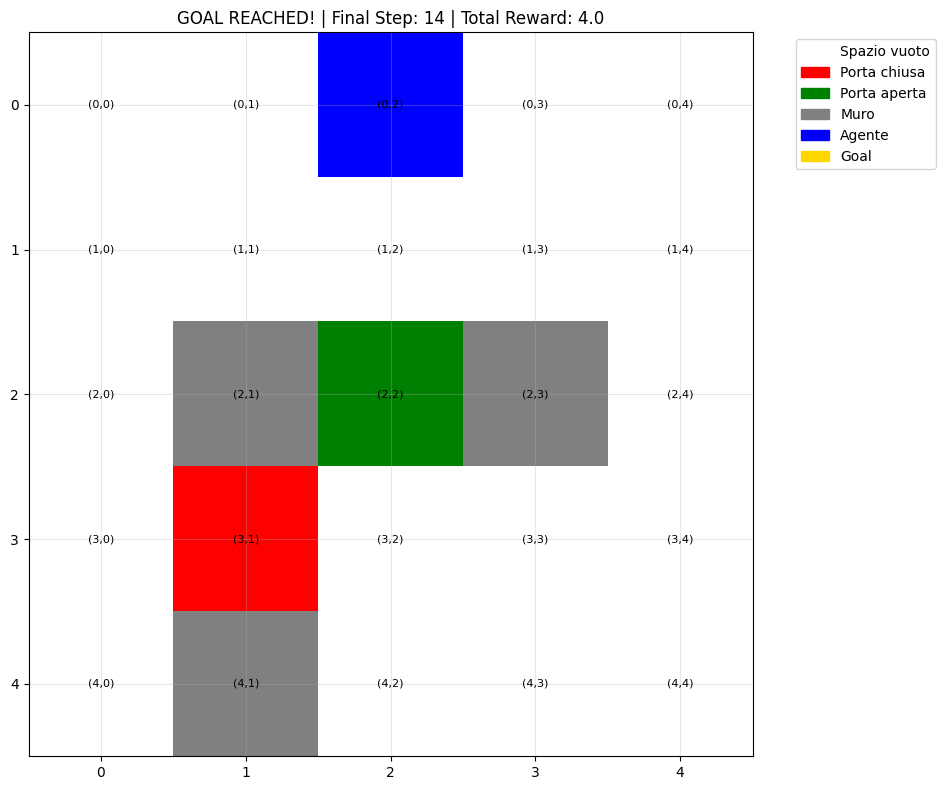

GIF salvata come q_learning_episode7.gif


[-0.1,
 0.05,
 -0.1,
 -0.1,
 -0.1,
 -0.1,
 -0.1,
 -0.1,
 -0.1,
 -0.1,
 -0.1,
 0.05,
 -0.1,
 5]

In [19]:
# Crea un nuovo ambiente e usa l'agente Q-learning addestrato
test_environment = GridWorld()
test_agent = q_agent  # Usa l'agente Q già addestrato
animate_episode(test_environment, test_agent, max_steps=200, delay=0.2, save_gif=True, gif_name="q_learning_episode8.gif")
#max_steps=500 for the 10x10 grid
